In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import itertools

import rdkit
import rdkit.Chem
import rdkit.Chem.PandasTools
import rdkit.Chem.Descriptors

In [2]:
sns.set(color_codes=True)
rdkit.Chem.PandasTools.RenderImagesInAllDataFrames(images=True)
SKIP_DRAW = False
SKIP_SHOW = True

In [35]:
CIRC_SMILE_REP = 10
csv_file = "raw_data.csv"
image_path = "images"

categorical_columns = [
    "polymer_class",
    "smiles_monomer",
    "additive",
    "polymer_concentration",
]
histo_columns = [
    "z_average",
    "temperature",
    "mean_count_rate",
    "intensity_mean",
    "number_mean",
    "dispersity",
    "mn",
    "pdi",
]

beautiful_cols = {
    **{c: c.capitalize().replace("_", " ") for c in histo_columns},
    **{c: c.capitalize().replace("_", " ") for c in categorical_columns},
    **{
        "z_average": "Z-Average",
        "mean_count_rate": "Diameter by mean count rate",
        "intensity_mean": "Diameter by intensity mean",
        "number_mean": "Diameter by number means",
    },
}
units = {
    **{c: None for c in histo_columns},
    **{c: None for c in categorical_columns},
    **{
        "z_average": "nm",
        "polymer_concentration": "g/L",
        "temperature": "°C",
        "mean_count_rate": "nm",
        "intensity_mean": "nm",
        "number_mean": "nm",
        "mn": "g/mol",
    },
}

# data cleanup parameter
z_average_cutoff = 500
dispersity_cutoff = 0.3
cutoff_size_disp = 200
cutoff_group_size = 3
cutoff_min_conc = 2
valid_threshold = 0.2

filter_map = {
    "polymer_class": ["methacrylate"],
}

remove_map = {
    "smiles_ru": ["[CH2][C](C)(C(=O)OC(C)(C)C)","[CH2][C](C)(C(=O)Oc1ccccc1)"],
}

name_conversion_map={
    "P01": "TS-001",
    "P02": "TS-005",
    "P03": "TS-002",
    "P04": "SB342",
    "P05": "SB343",
    "P06": "SB355",
    "P07": "TS-015a",
    "P08": "TS-015b",
    "P09": "TS-015c",
    "P10": "TS-016a",
    "P11": "TS-016b",
    "P12": "TS-016c",
    "P13": "TS-010a",
    "P14": "TS-010b",
    "P15": "TS-010c",
    "P16": "TS-012a",
    "P17": "TS-012b",
    "P18": "TS-012c",
    "P19": "TS-011a",
    "P20": "TS-011b",
    "P21": "TS-011c",
    "P22": "TS-013a",
    "P23": "TS-013b",
    "P24": "TS-013c",
    "P25": "TS-009a",
    "P26": "TS-009b",
    "P27": "TS-009c",
    "P28": "TS-019a",
    "P29": "TS-019b",
    "P30": "TS-019c",
    "P31": "TS-018a",
    "P32": "TS-018b",
    "P33": "TS-018c",
}
reverse_name_conversion_map={v:k for k,v in name_conversion_map.items()}
# train_outsmiles='C3[C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C)[CH2][C](C)(C(=O)OCC(C)C)3'

In [4]:
image_path = os.path.abspath(image_path)
os.makedirs(image_path, exist_ok=True)
image_path_dist = os.path.join(image_path, "dists")
os.makedirs(image_path_dist, exist_ok=True)
image_path_hist = os.path.join(image_path, "hists")
os.makedirs(image_path_hist, exist_ok=True)

image_path_group = os.path.join(image_path, "group_size_conc")
os.makedirs(image_path_group, exist_ok=True)

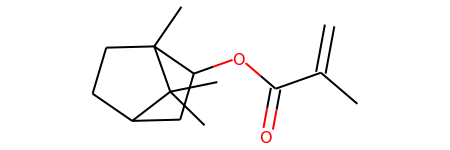

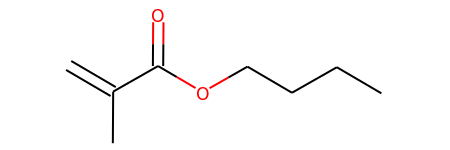

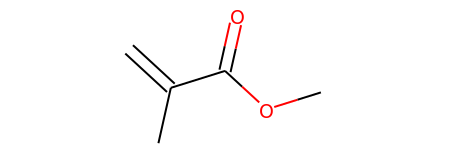

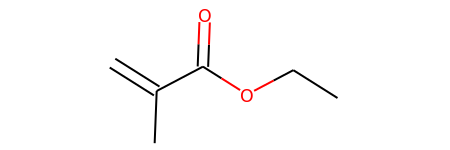

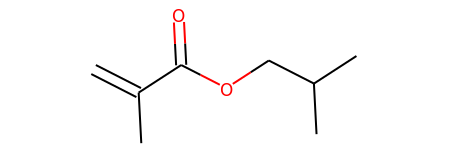

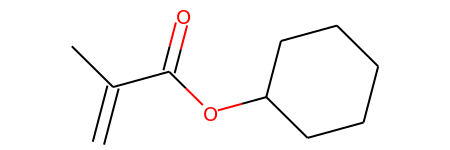

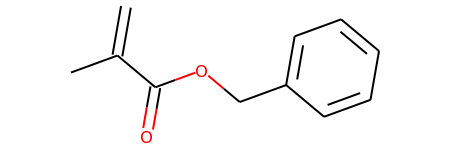

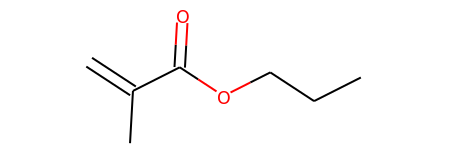

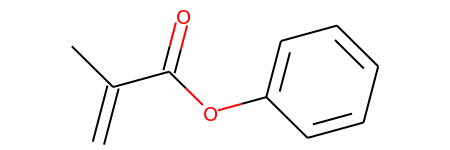

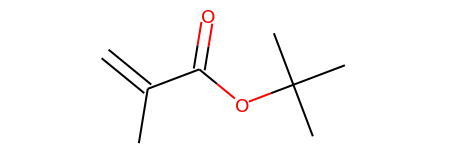

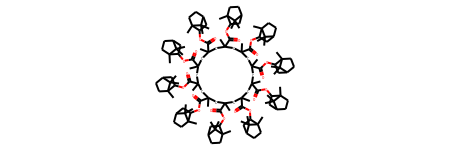

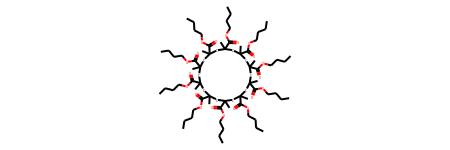

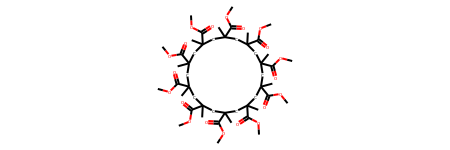

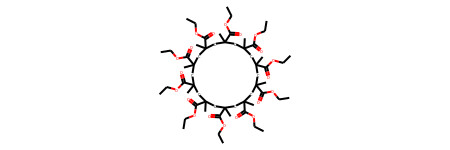

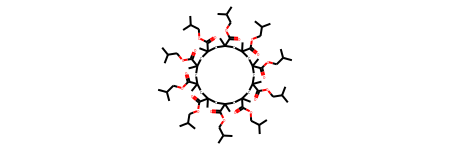

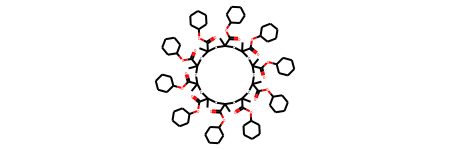

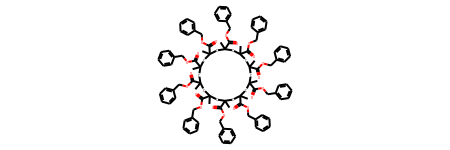

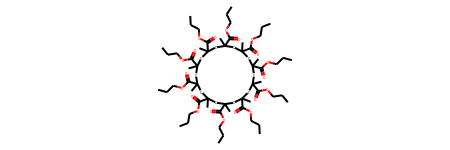

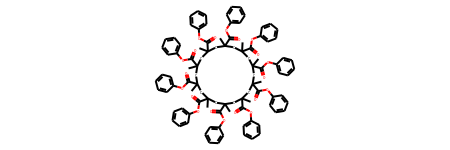

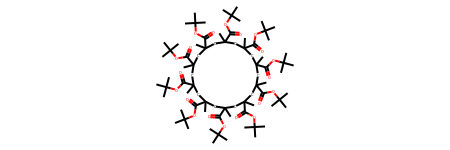

In [5]:
df = pd.read_csv(csv_file)
df["substance_code"]=df["substance_code"].apply(lambda c: reverse_name_conversion_map[c])

unique_smiles = list(df["smiles_monomer"].unique())
mols = [rdkit.Chem.MolFromSmiles(smiles) for smiles in unique_smiles]

for i, un_smiles in enumerate(unique_smiles):
    boolrange = df["smiles_monomer"] == un_smiles
    df.loc[boolrange, "monomer_mol"] = mols[i]

    display(mols[i])

unique_smiles = list(df["smiles_ru"].unique())
mols = [rdkit.Chem.MolFromSmiles(smiles) for smiles in unique_smiles]

circle_smiles = [
    (
        smiles * CIRC_SMILE_REP
        + str(max(map(int, [e for e in re.split("[^0-9]", smiles) if e != ""])) + 1)
    ).replace(
        "[CH2]",
        "C"
        + str(max(map(int, [e for e in re.split("[^0-9]", smiles) if e != ""])) + 1),
        1,
    )
    for smiles in unique_smiles
]
circle_mols = [rdkit.Chem.MolFromSmiles(smiles) for smiles in circle_smiles]

for i, un_smiles in enumerate(unique_smiles):
    boolrange = df["smiles_ru"] == un_smiles
    df.loc[boolrange, "repeating_unit_mol"] = mols[i]
    df.loc[boolrange, "mass_ru"] = rdkit.Chem.Descriptors.MolWt(mols[i])
    df.loc[boolrange, "circular_smiles_{}".format(CIRC_SMILE_REP)] = circle_smiles[i]
    df.loc[boolrange, "circ_mol"] = circle_mols[i]
    display(circle_mols[i])

df["dp"] = df["mn"] / df["mass_ru"]

In [6]:
print(df["smiles_ru"].unique())
for k, g in df.groupby(["polymer_class", "polymer"]):
    print(k)
    print(g["dp"].unique())
    print(g["smiles_ru"].unique())
    # display(g)

['[CH2][C](C)(C(=O)OC1CC2CCC1(C)C2(C)C)' '[CH2][C](C)(C(=O)OCCCC)'
 '[CH2][C](C)(C(=O)OC)' '[CH2][C](C)(C(=O)OCC)'
 '[CH2][C](C)(C(=O)OCC(C)C)' '[CH2][C](C)(C(=O)OC1CCCCC1)'
 '[CH2][C](C)(C(=O)OCc1ccccc1)' '[CH2][C](C)(C(=O)OCCC)'
 '[CH2][C](C)(C(=O)Oc1ccccc1)' '[CH2][C](C)(C(=O)OC(C)(C)C)']
('methacrylate', 'PMMA')
[ 164.8071756    81.90417212  263.69148097  296.65291609  146.82821099
 1012.81500644]
['[CH2][C](C)(C(=O)OC)']
('methacrylate', 'Poly-Ethyl MA')
[133.16512475  66.58256238 196.24334174]
['[CH2][C](C)(C(=O)OCC)']
('methacrylate', 'Poly-Isobornyl MA')
[ 83.66017776 120.54262171  55.32366594]
['[CH2][C](C)(C(=O)OC1CC2CCC1(C)C2(C)C)']
('methacrylate', 'Poly-Phenyl MA')
[171.40602264  66.58939009 114.68172738]
['[CH2][C](C)(C(=O)Oc1ccccc1)']
('methacrylate', 'Poly-Propyl MA')
[223.13939971  81.14159989 127.95406137]
['[CH2][C](C)(C(=O)OCCC)']
('methacrylate', 'Poly-butyl MA')
[179.3274167   66.80825328 110.40942911]
['[CH2][C](C)(C(=O)OCCCC)']
('methacrylate', 'Poly-c-hexyl MA'

In [7]:
df["with_pva"] = (df["additive"] == "PVA") * 1

In [8]:
step = 0
df["valid"] = 1


def displot(prefix, col, label=None):
    fig = plt.figure()
    ax = sns.countplot(x=df[df["valid"] > 0][col].fillna("None"))
    plt.title("Distribution")
    plt.ylabel("count")
    if label:
        plt.xlabel(label)
    elif col in beautiful_cols:
        plt.xlabel(beautiful_cols[col])
    plt.xticks(rotation=90)

    h_max = 0
    for p in ax.patches:
        h_max = max(h_max, p.get_height())

    all_heights = sum([p.get_height() for p in ax.patches])
    for p in ax.patches:
        ax.annotate(
            "{:.2f}%".format(100 * p.get_height() / all_heights),
            (p.get_x() + p.get_width() / 2, h_max * 0.05),  # x text postion
            rotation=90,  # text rotation
            ha="center",  # horizontal anchor of text
            va="bottom",
        )
    plt.tight_layout()
    # fig.autofmt_xdate()
    plt.savefig(os.path.join(image_path_dist, "{}_{}.png".format(prefix, col)), dpi=200)
    if not SKIP_SHOW:
        plt.show()  # shows the plot
    plt.close()  # close the current plot to display new


def histplot(prefix, col, label=None):
    sizes = np.array(df[df["valid"] > 0][col])
    sns.histplot(data=sizes, bins=50)
    if label:
        plt.xlabel(label)
    elif col in beautiful_cols:
        plt.xlabel(beautiful_cols[col])
    plt.ylabel("count")
    plt.xlabel(
        beautiful_cols[col]
        + (" [{}]".format(units[col]) if units[col] is not None else "")
    )
    plt.title("Histogram of {}".format(beautiful_cols[col]))
    plt.savefig(os.path.join(image_path_hist, "{}_{}.png".format(prefix, col)), dpi=200)
    if not SKIP_SHOW:
        plt.show()
    plt.close()


def display_df(prefix=None, hist=True, dist=True, title=True):
    global step
    if prefix is None:
        prefix = step
    print(len(df[df["valid"] > 0]), "data points in step", prefix)
    if not SKIP_DRAW:
        # z-average plot

        if hist:
            for col in histo_columns:
                if col in df.columns:
                    histplot(prefix, col)

        if dist:
            for col in categorical_columns:
                if col in df.columns:
                    displot(prefix, col)

        x_col = "polymer_concentration"
        y_col = "z_average"
        for key, group in df.groupby(["substance_code"]):
            # for subkey, subgroup in df.groupby(["mn"]):
            fig, ax1 = plt.subplots()
            plt.xlabel(
                beautiful_cols[x_col]
                + (" [{}]".format(units[x_col]) if units[x_col] is not None else "")
            )
            plt.ylabel(
                beautiful_cols[y_col]
                + (" [{}]".format(units[y_col]) if units[y_col] is not None else "")
            )
            # ax2 = ax1.twinx()
            markeriter = itertools.cycle(("X", "o", "+", "*", ",", "."))
            palette = itertools.cycle(sns.color_palette())
            lines = []
            for subkey, subgroup in group.groupby(["with_pva"]):
                color = next(palette)
                marker = next(markeriter)
                data = subgroup[subgroup["valid"] > 0]
                x = data[x_col]
                y = data[y_col]
                xe = []
                ye = []
                ee = []
                for c, cgroup in data.groupby([x_col]):
                    xe.append(c)
                    ye.append(cgroup[y_col].mean())
                    ee.append(cgroup[y_col].std())
                xe = np.array(xe)
                ye = np.array(ye)
                ee = np.array(ee)

                line1 = ax1.plot(
                    xe,
                    ye,
                    label=("with PVA" if subkey else "without PVA"),
                    color=color,
                    marker=marker,
                    markeredgecolor="w",
                )
                lines.extend(line1)
                ax1.plot(xe, ye + ee, alpha=0.3, color=color)
                ax1.plot(xe, ye - ee, alpha=0.3, color=color)
                ax1.fill_between(xe, ye - ee, ye + ee, alpha=0.2, color=color)
                ax1.plot(
                    x, y, marker=marker, linestyle="", color=color, markeredgecolor="w"
                )

                vx = []
                vy = []
                for c, vgroup in subgroup.groupby([x_col]):
                    vx.append(c)
                    vy.append(vgroup["valid"].mean())

                rvy = []
                for i in range(len(vy)):
                    rvy.append(
                        sum(*[vy[max(i - 2, 0) : min(i + 2, len(vy))]])
                        / len(vy[max(i - 2, 0) : min(i + 2, len(vy))])
                    )

                i = 0
                for c, vgroup in subgroup.groupby([x_col]):
                    df.loc[vgroup.index, "roll_valid"] = rvy[i]
                    i += 1

                # line2 = ax2.plot(vx,rvy,"--",color=color,label="validity {}".format(subkey))
                # lines.extend(line2)
                if title:
                    ax1.set_title("{} ({})".format(key, group["polymer"].values[0]))
                # handles, labels = ax.get_legend_handles_labels()
            # ax2.set_ylim([0,1.1])
            label = [l.get_label() for l in lines]
            plt.legend(lines, label)

            # plt.legend(label,title="additive")
            # ax2.legend(title="additive")
            # handles, labels = ax1.get_legend_handles_labels()
            # plt.legend([""]+handles[:3], ["additive"]+labels[:3])
            plt.savefig(
                os.path.join(image_path_group, "{}_{}.png".format(prefix, key)), dpi=200
            )
            if not SKIP_SHOW:
                plt.show()
            plt.close()
    step += 1


display_df()

3753 data points in step 0


In [9]:
pre_val = df["valid"].copy()
df.loc[df["z_average"] > z_average_cutoff, "valid"] = 0

display_df()
print(df[pre_val != df["valid"]]["substance_code"].unique())

3454 data points in step 1
['P32' 'P15' 'P02' 'P08' 'P16' 'P22' 'P24' 'P18' 'P13' 'P26' 'P23' 'P04'
 'P25' 'P12' 'P30' 'P28' 'P11' 'P17' 'P27' 'P29' 'P14' 'P21' 'P33']


In [10]:
pre_val = df["valid"].copy()
df.loc[df["dispersity"] > dispersity_cutoff, "valid"] = 0
display_df()
print(df[pre_val != df["valid"]]["substance_code"].unique())

3093 data points in step 2
['P32' 'P15' 'P02' 'P08' 'P06' 'P16' 'P22' 'P18' 'P07' 'P05' 'P13' 'P01'
 'P26' 'P23' 'P04' 'P25' 'P12' 'P30' 'P10' 'P28' 'P11' 'P17' 'P27' 'P29'
 'P14' 'P21' 'P19' 'P33' 'P09' 'P31']


In [11]:
from scipy.stats import t, zscore


def grubbs(X, test="two-tailed", alpha=0.05):

    """
    Performs Grubbs' test for outliers recursively until the null hypothesis is
    true.
    Parameters
    ----------
    X : ndarray
        A numpy array to be tested for outliers.
    test : str
        Describes the types of outliers to look for. Can be 'min' (look for
        small outliers), 'max' (look for large outliers), or 'two-tailed' (look
        for both).
    alpha : float
        The significance level.
    Returns
    -------
    X : ndarray
        The original array with outliers removed.
    outliers : ndarray
        An array of outliers.
    """

    Z = zscore(X, ddof=1)  # Z-score
    N = len(X)  # number of samples

    # create array to store outliers
    outliers = np.array([])

    if N == 0:
        return X, outliers

    # calculate extreme index and the critical t value based on the test
    if test == "two-tailed":
        extreme_ix = lambda Z: np.abs(Z).argmax()
        t_crit = lambda N: t.isf(alpha / (2.0 * N), N - 2)
    elif test == "max":
        extreme_ix = lambda Z: Z.argmax()
        t_crit = lambda N: t.isf(alpha / N, N - 2)
    elif test == "min":
        extreme_ix = lambda Z: Z.argmin()
        t_crit = lambda N: t.isf(alpha / N, N - 2)
    else:
        raise ValueError("Test must be 'min', 'max', or 'two-tailed'")

    # compute the threshold
    thresh = (
        lambda N: (N - 1.0)
        / np.sqrt(N)
        * np.sqrt(t_crit(N) ** 2 / (N - 2 + t_crit(N) ** 2))
    )

    # loop throught the array and remove any outliers
    while abs(Z[extreme_ix(Z)]) > thresh(N):

        # update the outliers
        outliers = np.r_[outliers, X[extreme_ix(Z)]]
        # remove outlier from array
        X = np.delete(X, extreme_ix(Z))
        # repeat Z score
        Z = zscore(X, ddof=1)
        N = len(X)

    return X, outliers

In [12]:
pre_val = df["valid"].copy()
grouping = ["substance_code", "additive", "polymer_concentration"]
all_colums_of_interest = ["z_average"]

for key, group in df[df["valid"] > 0].groupby(grouping):
    for c in all_colums_of_interest:
        non_outliers, outliers = grubbs(group[c].values, alpha=0.1)
        for i in outliers:
            df.loc[group.index[group[c] == i], "valid"] = 0
display_df()
print(df[pre_val != df["valid"]]["substance_code"].unique())

/home/julian/anaconda3/envs/nanoparticle_size_prediction/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/julian/anaconda3/envs/nanoparticle_size_prediction/lib/python3.7/site-packages/numpy/core/_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


3052 data points in step 3
['P32' 'P15' 'P08' 'P24' 'P07' 'P13' 'P26' 'P04' 'P30' 'P10' 'P28' 'P11'
 'P17' 'P27' 'P29' 'P14' 'P19' 'P09' 'P31' 'P03']


In [13]:
pre_val = df["valid"].copy()
grouping = ["substance_code", "additive", "polymer_concentration"]
all_colums_of_interest = ["z_average"]

for key, group in df[df["valid"] > 0].groupby(grouping):
    for c in all_colums_of_interest:
        if group[c].max() - group[c].min() > cutoff_size_disp:
            df.loc[group.index, "valid"] = 0
display_df()
print(df[pre_val != df["valid"]]["substance_code"].unique())

3035 data points in step 4
['P32' 'P22']


In [14]:
pre_val = df["valid"].copy()
grouping = ["substance_code", "additive", "polymer_concentration"]
all_colums_of_interest = ["z_average"]

for key, group in df[df["valid"] > 0].groupby(grouping):
    for c in all_colums_of_interest:
        if group[c].size < cutoff_group_size:
            df.loc[group.index, "valid"] = 0
display_df()
print(df[pre_val != df["valid"]]["substance_code"].unique())

3010 data points in step 5
['P08' 'P16' 'P22' 'P13' 'P26' 'P04' 'P30' 'P10' 'P28' 'P11' 'P27' 'P33']


In [15]:
pre_val = df["valid"].copy()
grouping = ["substance_code", "additive", "polymer_concentration"]
mean_df = pd.DataFrame(columns=grouping + ["z_average", "indices"])
l = 0
for key, group in df[df["valid"] > 0].groupby(grouping):
    d = dict(zip(grouping, key))
    d["z_average"] = group["z_average"].mean()
    d["indices"] = group.index.values
    mean_df.loc[l] = d
    l += 1

grouping = ["substance_code", "additive"]
for key, group in mean_df.sort_values("polymer_concentration").groupby(grouping):
    for i in reversed(range(1, len(group["z_average"]))):
        if group["z_average"].values[i] - group["z_average"].values[i - 1] < 0:
            df.loc[group["indices"].values[i], "valid"] = 0
        else:
            break

display_df()
print(df[pre_val != df["valid"]]["substance_code"].unique())

2917 data points in step 6
['P15' 'P16' 'P22' 'P07' 'P13' 'P17' 'P14' 'P33' 'P09']


In [16]:
pre_val = df["valid"].copy()
grouping = ["substance_code", "additive", "polymer_concentration"]
mean_df = pd.DataFrame(columns=grouping + ["z_average", "indices"])
l = 0
for key, group in df[df["valid"] > 0].groupby(grouping):
    d = dict(zip(grouping, key))
    d["z_average"] = group["z_average"].mean()
    d["indices"] = group.index.values
    mean_df.loc[l] = d
    l += 1

grouping = ["substance_code", "additive"]
for key, group in mean_df.sort_values("polymer_concentration").groupby(grouping):
    for i in range(len(group["z_average"]) - 1):
        # print(group["z_average"].values[i+1] , group["z_average"].values[i],group["z_average"].values[i+1] - group["z_average"].values[i])
        if group["z_average"].values[i + 1] - group["z_average"].values[i] < 0:
            df.loc[group["indices"].values[i], "valid"] = 0
        else:
            break


display_df()
print(df[pre_val != df["valid"]]["substance_code"].unique())

2823 data points in step 7
['P32' 'P08' 'P24' 'P05' 'P01' 'P23' 'P04' 'P12' 'P28' 'P20' 'P17' 'P21']


In [17]:
pre_val = df["valid"].copy()
cutoff_min_conc = 2

grouping = ["substance_code", "additive"]
all_colums_of_interest = ["z_average"]

for key, group in df[df["valid"] > 0].groupby(grouping):
    if len(group["polymer_concentration"].unique()) < cutoff_min_conc:
        df.loc[group.index, "valid"] = False

display_df()
print(df[pre_val != df["valid"]]["substance_code"].unique())

2813 data points in step 8
['P33']


In [18]:
stds = []
std_errors = []
rel_errors = []
means = []
group_sizes = []
for k, group in df[df["valid"] > 0].groupby(
    ["substance_code", "additive", "polymer_concentration"]
):
    size = group["z_average"]
    std = size.std()
    error = np.abs((size - size.mean()))
    std_calc = np.sqrt((error ** 2).sum() / (len(size) - 1))
    # print(std,std_calc)
    rel_error = np.abs((size - size.mean()) / size.mean())
    std_errors.append(std / len(size))
    df.loc[group.index, "mean_z_average"] = size.mean()
    stds.append(std)
    means.append(size.mean())
    group_sizes.append(len(size))

stds = np.abs(stds)
std_errors = np.abs(std_errors)
means = np.abs(means)
group_sizes = np.abs(group_sizes)

error = np.abs(df[df["valid"] > 0]["z_average"] - df[df["valid"] > 0]["mean_z_average"])
rel_error = error / df[df["valid"] > 0]["z_average"]

coeeff_of_var = stds / means
coeeff_of_var_star = (1 + 1 / (4 * group_sizes)) * coeeff_of_var
print("mean rel error", 100 * rel_error.mean())
print("coeeff of variation", 100 * coeeff_of_var.mean())
print("coeeff of variation*", 100 * coeeff_of_var_star.mean())
print("mean std errors", std_errors.mean())

mean rel error 2.9726905137526147
coeeff of variation 3.776294581424955
coeeff of variation* 3.90214058726348
mean std errors 1.212221845593829


In [19]:
display_df("final", hist=False, dist=False, title=False)

2813 data points in step final


In [20]:
stat_df = (
    df[df["valid"] > 0]
    .groupby(["substance_code", "additive", "polymer_concentration"])
    .describe()["z_average"]
)

In [21]:
stat_df["var"] = stat_df["std"] ** 2


stat_df["coeff_of_var"] = stat_df["std"] / stat_df["mean"]
stat_df["coeff_of_var_star"] = stat_df["coeff_of_var"] * (
    1 + 1 / (4 * stat_df["count"])
)

stat_df["std_error"] = stat_df["std"] / np.sqrt(stat_df["count"])
stat_df["rel_std_error"] = stat_df["std_error"] / stat_df["mean"]


stat_df_res = stat_df.reset_index()

In [22]:
stat_df.to_excel('stat_report.xlsx')

In [23]:
stat_df_res

,substance_code,additive,polymer_concentration,count,mean,std,min,25%,50%,75%,max,var,coeff_of_var,coeff_of_var_star,std_error,rel_std_error
0,P01,None,3,9.0,161.955556,5.364492,154.0,159.400,163.0,166.10,169.9,28.777778,0.033123,0.034043,1.788164,0.011041
1,P01,None,5,9.0,175.300000,5.609813,165.0,173.300,174.5,176.40,184.0,31.470000,0.032001,0.032890,1.869938,0.010667
2,P01,None,8,9.0,197.666667,4.658594,192.6,193.100,199.2,199.90,206.6,21.702500,0.023568,0.024223,1.552865,0.007856
3,P01,None,10,9.0,214.677778,5.082022,207.8,210.500,215.0,218.90,221.2,25.826944,0.023673,0.024330,1.694007,0.007891
4,P01,None,15,3.0,254.266667,3.280752,250.5,253.150,255.8,256.15,256.5,10.763333,0.012903,0.013978,1.894143,0.007449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,P32,PVA,8,7.0,265.571429,7.209881,256.4,260.700,265.7,268.80,277.9,51.982381,0.027149,0.028118,2.725079,0.010261
336,P32,PVA,10,8.0,265.212500,8.061272,253.5,259.825,266.0,270.90,275.9,64.984107,0.030396,0.031345,2.850090,0.010746
337,P32,PVA,15,7.0,248.928571,5.507484,241.8,245.200,247.3,253.60,255.8,30.332381,0.022125,0.022915,2.081633,0.008362
338,P32,PVA,20,9.0,254.333333,9.451852,242.0,244.500,255.8,262.70,266.7,89.337500,0.037163,0.038196,3.150617,0.012388


In [24]:
100 * stat_df_res["rel_std_error"].mean()

1.3619734667953465

In [25]:
100 * stat_df_res["coeff_of_var_star"].mean()

3.90214058726348

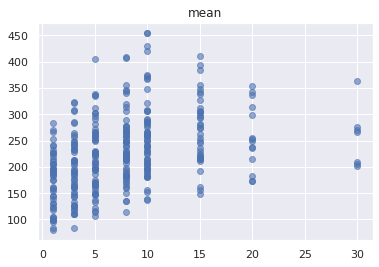

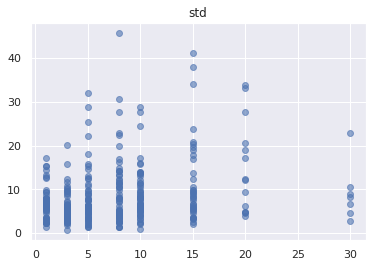

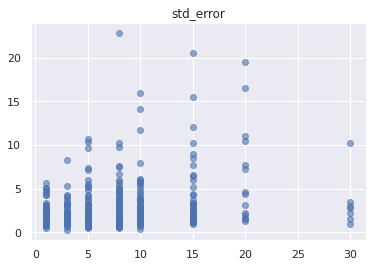

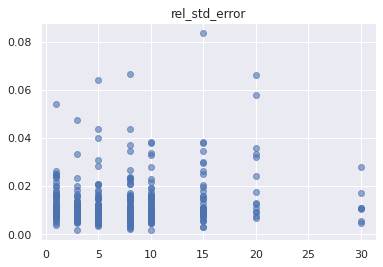

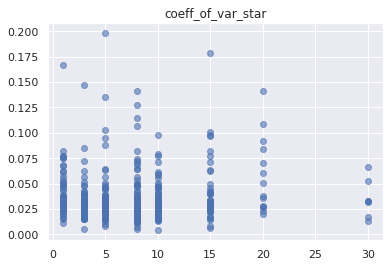

In [26]:
plt.plot(stat_df_res["polymer_concentration"], stat_df_res["mean"], "o", alpha=0.6)
plt.title("mean")
plt.show()
plt.close()
plt.plot(stat_df_res["polymer_concentration"], stat_df_res["std"], "o", alpha=0.6)
plt.title("std")
plt.show()
plt.close()
plt.plot(stat_df_res["polymer_concentration"], stat_df_res["std_error"], "o", alpha=0.6)
plt.title("std_error")
plt.show()
plt.close()
plt.plot(stat_df_res["polymer_concentration"], stat_df_res["rel_std_error"], "o", alpha=0.6)
plt.title("rel_std_error")
plt.show()
plt.close()
plt.plot(
    stat_df_res["polymer_concentration"],
    stat_df_res["coeff_of_var_star"],
    "o",
    alpha=0.6,
)
plt.title("coeff_of_var_star")
plt.show()
plt.close()

In [27]:
fn = "z_average_cutoff_{}_dispersity_cutoff_{}_cutoff_size_disp_{}_cutoff_group_size_{}_cutoff_min_conc_{}_valid_threshold_{}_smiles_out_{}".format(
    z_average_cutoff,
    dispersity_cutoff,
    cutoff_size_disp,
    cutoff_group_size,
    cutoff_group_size,
    valid_threshold,
    ".".join(remove_map["smiles_ru"]),
)
fn

'z_average_cutoff_500_dispersity_cutoff_0.3_cutoff_size_disp_200_cutoff_group_size_3_cutoff_min_conc_3_valid_threshold_0.2_smiles_out_[CH2][C](C)(C(=O)OC(C)(C)C).[CH2][C](C)(C(=O)Oc1ccccc1'

In [36]:
df["with_pva"] = (df["additive"] == "PVA") * 1
train_size_df = df.drop(["monomer_mol", "circ_mol", "repeating_unit_mol"], axis=1)
train_size_df = train_size_df.drop(
    train_size_df[train_size_df["valid"] < valid_threshold].index, axis=0
)
train_size_df = train_size_df.drop(
    train_size_df[train_size_df["roll_valid"] < valid_threshold].index, axis=0
)
# .to_csv("processed_data.csv",index=False)


out_indiceses = []
for col, in_list in filter_map.items():
    out = list(set(train_size_df[col].unique()) - set(in_list))
    print(out)
    out_indices = train_size_df[train_size_df[col].isin(out)].index
    out_indiceses.extend(out_indices)

for col, in_list in remove_map.items():
    keep = list(set(train_size_df[col].unique()) - set(in_list))
    print(col,keep,in_list)
    out_indices = train_size_df[~train_size_df[col].isin(keep)].index
    out_indiceses.extend(out_indices)


out_indiceses = np.array(list(set(out_indiceses)), dtype=int)
in_indices = np.array(list(set(train_size_df.index) - set(out_indiceses)), dtype=int)

print(len(train_size_df.index), len(in_indices), len(out_indiceses))

train_size_df.loc[in_indices].to_csv(
    "train_data_size_kept_{}.csv".format(fn), index=False
)
train_size_df.loc[out_indiceses].to_csv(
    "train_data_size_removed_{}.csv".format(fn), index=False
)

train_valid_df = df.drop(["monomer_mol", "circ_mol", "repeating_unit_mol"], axis=1)
train_valid_df.to_csv("train_data_valid_{}.csv".format(fn), index=False)

[]
smiles_ru ['[CH2][C](C)(C(=O)OCC(C)C)', '[CH2][C](C)(C(=O)OCc1ccccc1)', '[CH2][C](C)(C(=O)OC1CC2CCC1(C)C2(C)C)', '[CH2][C](C)(C(=O)OCCC)', '[CH2][C](C)(C(=O)OCCCC)', '[CH2][C](C)(C(=O)OCC)', '[CH2][C](C)(C(=O)OC1CCCCC1)', '[CH2][C](C)(C(=O)OC)'] ['[CH2][C](C)(C(=O)OC(C)(C)C)', '[CH2][C](C)(C(=O)Oc1ccccc1)']
2807 2344 463


In [29]:
pd.util.hash_pandas_object(train_size_df.loc[in_indices])

9       11004645463309113179
10        307202311212436345
11       6036164870715132556
12      17786164911141446154
13      15424362271161002600
                ...         
3748    16569496824609560074
3749     8919861856242331913
3750    13070048586869454373
3751    11525484130361562371
3752    17238121511552626045
Length: 2527, dtype: uint64

In [30]:
keep_df = train_size_df.loc[in_indices].reset_index(drop=True)
keep_df.columns

Index(['measurment_data', 'sample', 'temperature', 'z_average', 'dispersity',
       'mean_count_rate', 'volume_mean', 'intensity_mean', 'number_mean',
       'file', 'np_formulation', 'substance_code', 'polymer_class', 'polymer',
       'smiles_monomer', 'smiles_ru', 'mn', 'pdi', 'mn_method', 'tg', 'date',
       'additive', 'polymer_concentration', 'mass_ru', 'circular_smiles_10',
       'dp', 'with_pva', 'valid', 'roll_valid', 'mean_z_average'],
      dtype='object')

In [31]:
stat_data = (
    keep_df[["polymer", "dp", "additive", "polymer_concentration", "z_average"]]
    .groupby(["polymer", "dp", "additive", "polymer_concentration"])
    .describe()
)
stat_datatle

NameError: name 'stat_datatle' is not defined

In [ ]:
(stat_data[("z_average", "max")] - stat_data[("z_average", "min")])[176]

In [ ]:
stat_data.iloc[176]

In [ ]:
len(df.substance_code.unique())